In [1]:
import os
import torch
from torchinfo import summary

In [2]:
# import module
from IKP.model.Predictor import Predictor
from IKP.model.SFTMD import SFTMD

from utils.gaussian_kernel import make_and_save
from utils.dataset import get_datasets
from utils.dataloader import get_dataloader
from utils.plot_image import plot
from utils.utils import tensor2imgtensor

from IKP.codes.train import train
from IKP.codes.test import test

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

1.13.0+cu116
True


hyperparameters

In [4]:
args = dict(
    train = './data/train/',
    valid = './data/valid/',
    test = './data/test/Set5',
    kernel_path = './IKP',
    kernel_num = 10000,
    reduced_kernel_dim = 32,
    scale = 4,
    batch_size = 24,
    lr = 1e-4,
    beta1 = 0.9,
    beta2 = 0.99,
    step_size = 10,
    gamma = 0.95,
    num_epoch = 50,
    num_iter = 3,
    device = device,
    log_interval = 50,
    ckpt_dir = './IKP/checkpoints',
    result_dir = './IKP/results',
    sftmd_train = False,
)

Make Gaussian kernels and Save kernels

In [5]:
make_and_save(args)

creating kernel dict is complete


Load Datasets for Classifier

In [6]:
train_ds, valid_ds, test_ds = get_datasets(args)

In [7]:
train_dl = get_dataloader(train_ds, args['batch_size'], shuffle=True)
valid_dl = get_dataloader(valid_ds, args['batch_size'], shuffle=False)
test_dl = get_dataloader(test_ds, 1, shuffle=False)

HR image shape:		 torch.Size([3, 144, 144])
LR image shape:		 torch.Size([3, 36, 36])
num of train image:	 3450


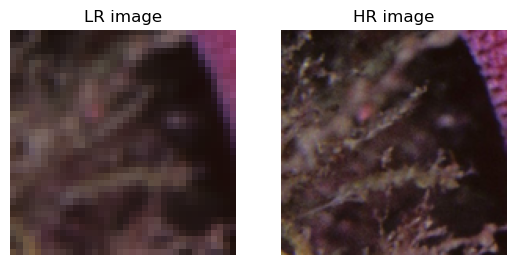

In [8]:
print('HR image shape:\t\t', train_ds[0]['HR'].shape)
print('LR image shape:\t\t', train_ds[0]['LR'].shape)
print('num of train image:\t', len(train_ds))

img1 = train_ds[0]
HR, LR = img1['HR'], img1['LR']
plot([tensor2imgtensor(LR), tensor2imgtensor(HR)], ['LR image', 'HR image'], (1, 2))

Model Info

In [9]:
sftmd = SFTMD(3, args['reduced_kernel_dim'], 64, 16, args['scale'])

dummy_LR = (args['batch_size'], 3, 144 // args['scale'], 144 // args['scale'])
dummy_kernel = (args['batch_size'], args['reduced_kernel_dim'])

print(summary(sftmd, [dummy_LR, dummy_kernel]))

Layer (type:depth-idx)                   Output Shape              Param #
SFTMD                                    [24, 3, 144, 144]         --
├─Sequential: 1-1                        [24, 64, 36, 36]          --
│    └─Conv2d: 2-1                       [24, 64, 36, 36]          1,792
│    └─LeakyReLU: 2-2                    [24, 64, 36, 36]          --
├─Sequential: 1-2                        [24, 64, 36, 36]          --
│    └─Conv2d: 2-3                       [24, 64, 36, 36]          36,928
│    └─LeakyReLU: 2-4                    [24, 64, 36, 36]          --
├─Sequential: 1-3                        [24, 64, 36, 36]          --
│    └─Conv2d: 2-5                       [24, 32, 36, 36]          27,680
│    └─LeakyReLU: 2-6                    [24, 32, 36, 36]          --
│    └─Conv2d: 2-7                       [24, 64, 36, 36]          18,496
├─Sigmoid: 1-4                           [24, 64, 36, 36]          --
├─Sequential: 1-5                        [24, 64, 36, 36]          --


In [10]:
predictor = Predictor(3, args['reduced_kernel_dim'], 128)

dummy_SR = (args['batch_size'], 3, 144, 144)

print(summary(predictor, dummy_SR))

Layer (type:depth-idx)                   Output Shape              Param #
Predictor                                [24, 32]                  --
├─Sequential: 1-1                        [24, 128, 144, 144]       --
│    └─Conv2d: 2-1                       [24, 128, 144, 144]       9,728
│    └─LeakyReLU: 2-2                    [24, 128, 144, 144]       --
├─Sequential: 1-2                        [24, 128, 144, 144]       --
│    └─Conv2d: 2-3                       [24, 128, 144, 144]       409,728
│    └─LeakyReLU: 2-4                    [24, 128, 144, 144]       --
├─Sequential: 1-3                        [24, 128, 144, 144]       --
│    └─Conv2d: 2-5                       [24, 128, 144, 144]       409,728
│    └─LeakyReLU: 2-6                    [24, 128, 144, 144]       --
├─Sequential: 1-4                        [24, 32, 144, 144]        --
│    └─Conv2d: 2-7                       [24, 32, 144, 144]        102,432
│    └─LeakyReLU: 2-8                    [24, 32, 144, 144]        

Train Estimator and SFTMD

In [11]:
if args['sftmd_train']:
    print("train sftmd & estimator start")
    train(train_dl, valid_dl, len(train_ds), predictor, sftmd, args)
    print("train sftmd & estimator end")

ckpt_path_p = os.path.join(args['ckpt_dir'], f"ckpt_predictor_x{args['scale']}.pth")
predictor.load_state_dict(torch.load(ckpt_path_p)['model_state_dict'])
print("load estimator:", ckpt_path_p)
    
ckpt_path_f = os.path.join(args['ckpt_dir'], f"ckpt_sftmd_x{args['scale']}.pth")
sftmd.load_state_dict(torch.load(ckpt_path_f)['model_state_dict'])
print("load sftmd:", ckpt_path_f)

load estimator: ./NEW1/checkpoints\ckpt_predictor_x4.pth
load sftmd: ./NEW1/checkpoints\ckpt_sftmd_x4.pth


Inference Model

Fri May  5 23:26:10 2023	[1/5]	test [mse: 0.00086  ssim: 0.86050  psnr: 30.66283]


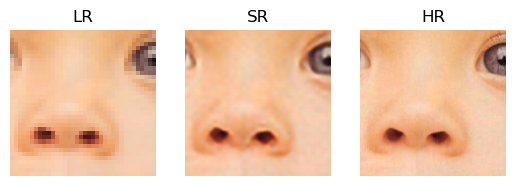

Fri May  5 23:26:11 2023	[2/5]	test [mse: 0.00142  ssim: 0.85725  psnr: 28.48651]


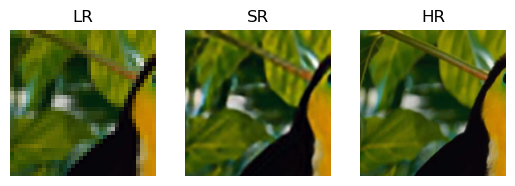

Fri May  5 23:26:11 2023	[3/5]	test [mse: 0.00536  ssim: 0.78167  psnr: 22.65775]


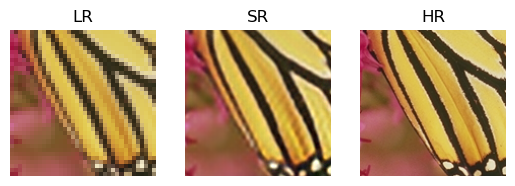

Fri May  5 23:26:12 2023	[4/5]	test [mse: 0.00122  ssim: 0.71474  psnr: 29.10529]


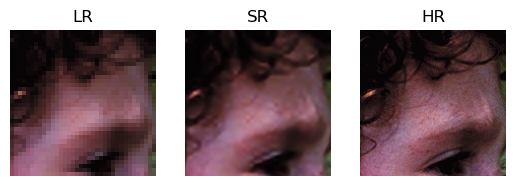

Fri May  5 23:26:12 2023	[5/5]	test [mse: 0.00234  ssim: 0.85494  psnr: 26.30438]


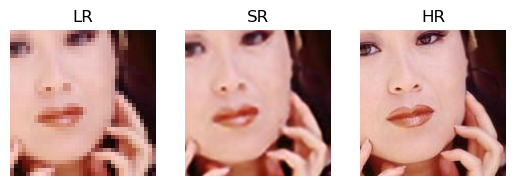

avg mse: 0.00224
avg ssim: 0.81382
avg psnr: 27.44335
avg time: 0.15552 sec


In [12]:
test(test_dl, len(test_ds), predictor, sftmd, args)